In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score,roc_curve
import numpy as np

In [3]:
# 保存されたCSVファイルを読み込んで確認 (任意)
stock_df = pd.read_csv('stock_data.csv')

In [4]:
stock_df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %,log(出来高),year,month,date,曜日,変化率_数値,week,変動幅,中間値
0,1987-02-12,182.4,182.4,182.4,182.4,1.28B,16.25%,9.107210,1987,2,12,3,16.25,0,0.0,182.40
1,1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%,8.625703,1987,2,13,4,-5.43,0,4.0,174.50
2,1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%,8.556917,1987,2,16,0,1.74,1,9.8,170.60
3,1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%,8.945227,1987,2,17,1,3.93,1,8.8,179.90
4,1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%,8.900416,1987,2,18,2,4.82,1,4.9,188.75


今回は変化率を予想する
株取引において、重要になるのは実際の価格よりも価格が上がるかどうかであるかである。
例えば、次の日に株価があがるかどうかを完全に予測することができれば、その日に買って次の日に売ることで利益を出すことができる
stock_dfの"変化率"カラムはその日の終値を一つ前の日の終値で割ったもの。
つまり、目的変数は次の日の変化率である

In [5]:
stock_df['目的変数'] = stock_df['変化率_数値'].shift(-1)

# 最後の行を削除
stock_df = stock_df[:-1]
stock_df.head()

,日付け,終値,始値,高値,安値,出来高,変化率 %,log(出来高),year,month,date,曜日,変化率_数値,week,変動幅,中間値,目的変数
0,1987-02-12,182.4,182.4,182.4,182.4,1.28B,16.25%,9.107210,1987,2,12,3,16.25,0,0.0,182.40,-5.43
1,1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%,8.625703,1987,2,13,4,-5.43,0,4.0,174.50,1.74
2,1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%,8.556917,1987,2,16,0,1.74,1,9.8,170.60,3.93
3,1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%,8.945227,1987,2,17,1,3.93,1,8.8,179.90,4.82
4,1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%,8.900416,1987,2,18,2,4.82,1,4.9,188.75,2.56


In [6]:
ml_stock_df = stock_df[['日付け','終値','始値','log(出来高)', 
                        '曜日','変動幅', '中間値', '目的変数']].copy()
cols_to_scale = ['終値', '始値', 'log(出来高)', '中間値', '変動幅']


ml_stock_df['日付け'] = pd.to_datetime(ml_stock_df['日付け'])
#分類タスクに帰着させる
ml_stock_df['目的変数'] = np.where(ml_stock_df['目的変数'] > 0, 1, 0)
ml_stock_df.head()

,日付け,終値,始値,log(出来高),曜日,変動幅,中間値,目的変数
0,1987-02-12,182.4,182.4,9.107210,3,0.0,182.40,0
1,1987-02-13,172.5,176.5,8.625703,4,4.0,174.50,1
2,1987-02-16,175.5,166.7,8.556917,0,9.8,170.60,1
3,1987-02-17,182.4,176.5,8.945227,1,8.8,179.90,1
4,1987-02-18,191.2,186.3,8.900416,2,4.9,188.75,1


今回は2013年以降のデータを用いる。また、テストデータは2023年以降を用いる

予測モデルを検討する
一般的に用いられるモデルとしてARIMAモデルのような自己回帰モデルとLSTMのような深層学習モデルを検討する
今回はLSTMモデルを用いる。理由としては、予測として株価自体ではなく翌日に上がるか下がるかを判別したい。
符号が重要なので分類タスクに帰着させたい。加えて、 EDAの結果から変化率の自己相関が弱いことがわかるからである

In [7]:
# LSTMモデルの定義
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,dropout_ratio):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_ratio)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out) 
        out = torch.relu(out) 
        out = self.dropout(out)
        out = self.fc2(out) 
        out = self.sigmoid(out) 
        return out

In [8]:
# 時系列分割交差検証
def time_series_cross_validation(train_data, n_splits, param_grid):
    #gpu使えるなら使う
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_score = 0
    best_params = {}

    for hidden_size in param_grid['hidden_size']:
        for epochs in param_grid['epochs']:
            for dropout_ratio in param_grid['dropout_ratio']:
                for learning_rate in param_grid['learning_rate']:
                    valid_scores = []
                    tscv = TimeSeriesSplit(n_splits=n_splits)

                    # 説明変数と目的変数を分離
                    X = train_data.drop("目的変数", axis=1).values
                    y = train_data["目的変数"].values

    
                    scaler = StandardScaler()
                    X = scaler.fit_transform(X)



                    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
                    y_tensor = torch.tensor(y, dtype=torch.float32).to(device)


                    for fold, (train_indices, valid_indices) in enumerate(tscv.split(X)):
                        X_train, X_valid = X_tensor[train_indices], X_tensor[valid_indices]
                        y_train, y_valid = y_tensor[train_indices], y_tensor[valid_indices]
                        
                        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
                        X_valid=X_valid.unsqueeze(1)

                        # LSTMモデルの初期化
                        input_size = X_train.shape[1]  # 特徴量の次元数

                        output_size = 1
                        model = LSTMModel(input_size, hidden_size, output_size,dropout_ratio).to(device)

                        # 損失関数とオプティマイザの定義
                        criterion = nn.BCELoss() 
                        optimizer = optim.Adam(model.parameters(),lr=learning_rate)

                        

                        for epoch in range(epochs):
                            model.train()
                            for batch_X, batch_y in train_loader:
                                batch_X = batch_X.unsqueeze(1).to(device)
                                batch_y = batch_y.to(device)
                                optimizer.zero_grad()
                                outputs = model(batch_X)
                                loss = criterion(outputs, batch_y.view(-1, 1))
                                loss.backward()
                                optimizer.step()


                        # 予測
                        model.eval()  # 推論モードにする
                        with torch.no_grad():
                            y_valid_pred = model(X_valid)


                        score = roc_auc_score(y_valid.numpy(), y_valid_pred.squeeze()) # CPUに戻してから計算
                

                        valid_scores.append(score)
        
                    score_= np.mean(valid_scores)
                    if score_ > best_score:
                        best_score = score_
                        best_params = {'hidden_size': hidden_size, 'epochs': epochs, 'dropout_ratio': dropout_ratio,'learning_rate':learning_rate}
            print(f"Best AUC: {best_score}")
            print(f"Best parameters: {best_params}")
            return best_params

In [12]:
def train_and_evaluate(train_data, test_data, best_params, batch_size=64):
    #手元の環境なのでcpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train = train_data.drop("目的変数", axis=1).values
    y_train = train_data["目的変数"].values
    X_test = test_data.drop("目的変数", axis=1).values
    y_test = test_data["目的変数"].values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)  # テストデータは訓練データのscalerでtransform

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    X_test_tensor = X_test_tensor.unsqueeze(1).to(device)

    input_size = X_train.shape[1]
    output_size = 1
    model = LSTMModel(input_size, best_params['hidden_size'], output_size, best_params['dropout_ratio']).to(device)

    criterion = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    for epoch in range(best_params['epochs']):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.unsqueeze(1).to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

    test_auc = roc_auc_score(y_test_tensor.cpu().numpy(), y_test_pred.cpu().squeeze().numpy())
    print(f"Test AUC: {test_auc}")

    fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu().numpy(), y_test_pred.cpu().squeeze().numpy())
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # ランダム分類器のROC曲線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return test_auc

In [9]:
ml_stock_df['年'] = ml_stock_df['日付け'].dt.year
ml_stock_df['月'] = ml_stock_df['日付け'].dt.month
ml_stock_df = ml_stock_df.drop("日付け", axis=1)

In [54]:
#2013年以降のデータを使用
train_data = ml_stock_df[(ml_stock_df['年'] >= 2013) & (ml_stock_df['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df[ml_stock_df['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/1603632541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/1603632541.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [55]:
# 時系列分割交差検証の実行
n_splits = 4
param_grid = {
    'hidden_size': [64,128,256,512],
    'epochs': [10,20,30,40],
    'dropout_ratio': [0.1,0.2,0.3],
    'learning_rate':[0.1,0.01,0.001]
}
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.526758766199157
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.2, 'learning_rate': 0.001}


Test AUC: 0.5004403875410361


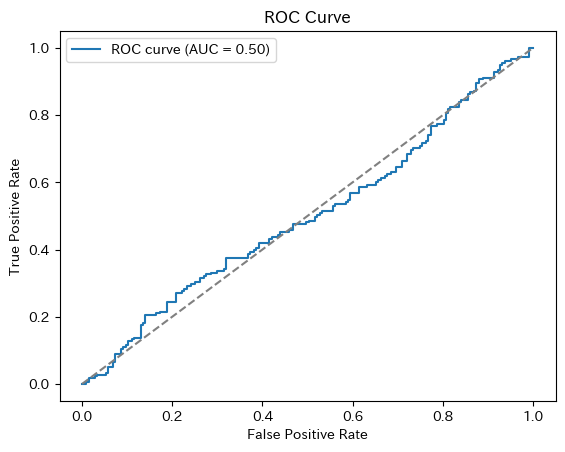

In [56]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)

性能改善を考える
まず第一に学習データの年数を変えてみる。
深層学習モデルでは学習元データが多い方が望ましいので2013年からのデータを学習データとしていたが2017年から2020年にかけて株価の停滞が見られる。これらのデータはイレギュラーデータとして予測に悪影響を与える可能性がある
そのため、まず2021以降のデータだけを学習データとして使ってみる

In [57]:
#2021年以降のデータを使用
train_data = ml_stock_df[(ml_stock_df['年'] >= 2021) & (ml_stock_df['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df[ml_stock_df['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/803052279.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/803052279.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [58]:
# 時系列分割交差検証の実行
n_splits = 4
param_grid = {
    'hidden_size': [64,128,256,512],
    'epochs': [10,20,30,40],
    'dropout_ratio': [0.1,0.2,0.3],
    'learning_rate':[0.1,0.01,0.001]
}
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.5662025635797878
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.3, 'learning_rate': 0.001}


Test AUC: 0.5029492620172418


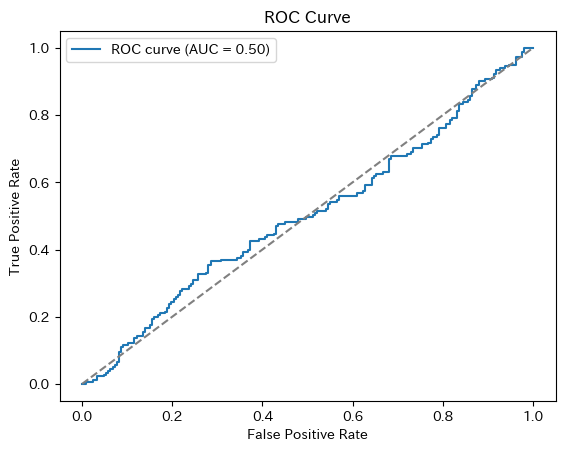

In [59]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)

始値と終値が非常に相関が強いため、説明変数として両方を用いる必要は薄いと考えられる
そのため、特徴量として、始値を使うのではなく、終値-始値の新たな特徴量を作る

In [60]:
#終値-始値を持った新たなdf、ml_stock_df_を作成
ml_stock_df_ = ml_stock_df.copy()  # 元のDataFrameを複製
ml_stock_df_["終値-始値"] = ml_stock_df_["終値"] - ml_stock_df_["始値"]
ml_stock_df_ = ml_stock_df_.drop("始値", axis=1)

In [61]:
#ml_stock_df_の2013年以降のデータ
train_data = ml_stock_df_[(ml_stock_df_['年'] >= 2013) & (ml_stock_df_['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df_[ml_stock_df_['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3392523291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3392523291.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [62]:
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.5475727768458405
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.3, 'learning_rate': 0.001}


Test AUC: 0.47412389569487823


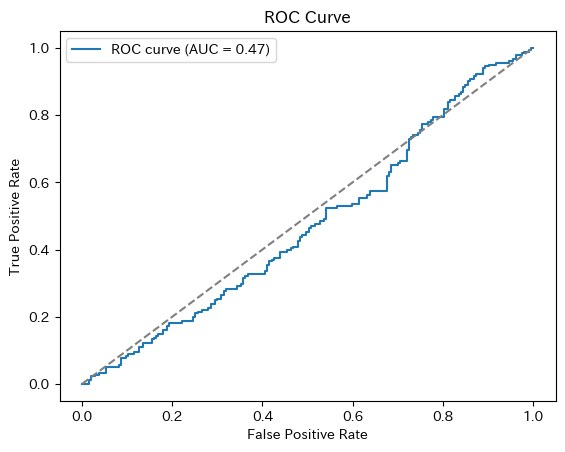

In [63]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)

In [64]:
#2021以降のデータを使用
train_data = ml_stock_df_[(ml_stock_df_['年'] >= 2021) & (ml_stock_df_['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df_[ml_stock_df_['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3026539631.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3026539631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [65]:
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.5744545323806084
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.3, 'learning_rate': 0.001}


Test AUC: 0.48624122561187183


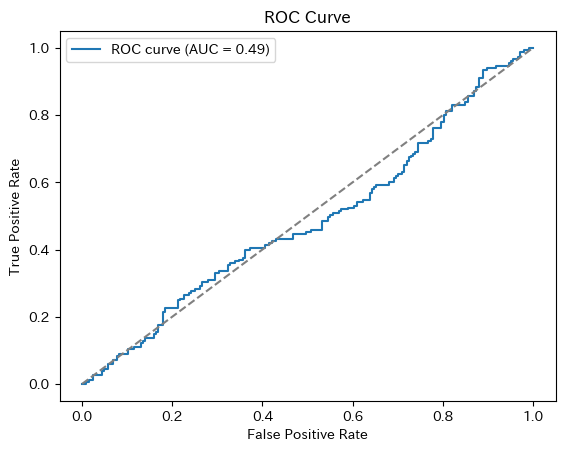

In [66]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)

In [24]:
ml_stock_df.head()

,終値,始値,log(出来高),曜日,変動幅,中間値,目的変数,年,月
0,182.4,182.4,9.107210,3,0.0,182.40,0,1987,2
1,172.5,176.5,8.625703,4,4.0,174.50,1,1987,2
2,175.5,166.7,8.556917,0,9.8,170.60,1,1987,2
3,182.4,176.5,8.945227,1,8.8,179.90,1,1987,2
4,191.2,186.3,8.900416,2,4.9,188.75,1,1987,2


In [67]:
#"始値","中間値"を削除
ml_stock_df__ = ml_stock_df.copy()  
ml_stock_df__ = ml_stock_df__.drop(["始値","中間値"],axis=1)

In [68]:
train_data = ml_stock_df__[(ml_stock_df__['年'] >= 2013) & (ml_stock_df__['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df__[ml_stock_df__['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/577458475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/577458475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [69]:
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.529966445249028
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.3, 'learning_rate': 0.001}


Test AUC: 0.4951290468946006


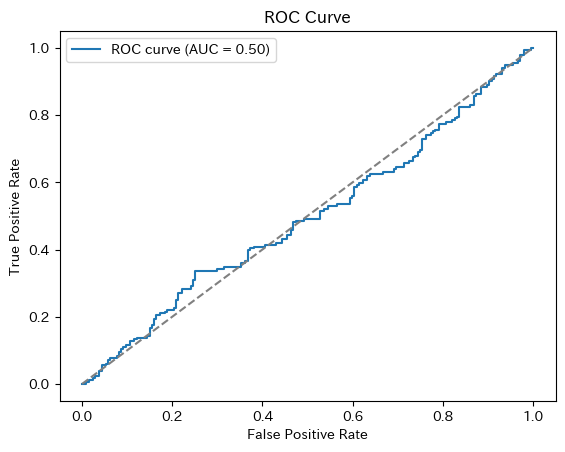

In [70]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)

In [71]:
train_data = ml_stock_df__[(ml_stock_df__['年'] >= 2021) & (ml_stock_df__['年'] <= 2022)]

# テストデータ
test_data = ml_stock_df__[ml_stock_df__['年']>= 2023]

train_data['年']=train_data['年']-1987
test_data['年']=test_data['年']-1987

/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3935963830.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['年']=train_data['年']-1987
/var/folders/6z/413ffqhx6158t32jth0zy1q00000gp/T/ipykernel_1824/3935963830.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['年']=test_data['年']-1987


In [72]:
best_params = time_series_cross_validation(train_data, n_splits,param_grid)

Best AUC: 0.5659618229986081
Best parameters: {'hidden_size': 64, 'epochs': 10, 'dropout_ratio': 0.3, 'learning_rate': 0.01}


Test AUC: 0.4887767902420797


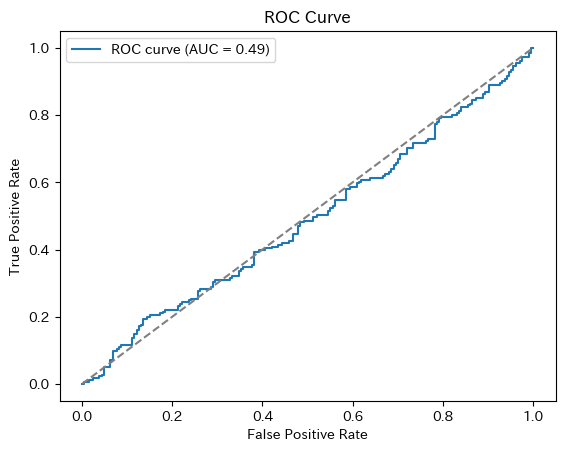

In [73]:
auc=train_and_evaluate(train_data, test_data, best_params, batch_size=64)